In [117]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [116]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [118]:
import glob
import os
import rasterio

In [32]:
train_nir="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/original_train"
train_mask="D:/Acres/January 2025/Assignment 8/AgriculturalField-Seg/train/groundtruth_train"

In [33]:
#Capture training image info as a list
train_nirs = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_nir):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_nirs.append(img)

In [22]:
#Capture training image info as a list
train_masks = []
# Assuming train_image is the directory pattern you want to search
for directory_path in glob.glob(train_mask):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        with rasterio.open(img_path) as src:
            img = src.read(1)  # Read the image as a numpy array (assuming it's a single-band image)
            train_masks.append(img)

c:\Users\Admin\anaconda3\envs\JintuEnv\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [35]:

print(train_nirs)


[array([[106, 112, 120, ...,  28,  27,  28],
       [ 95, 105, 117, ...,  32,  30,  30],
       [121, 120, 111, ...,  30,  28,  26],
       ...,
       [155, 137, 167, ..., 146, 148, 140],
       [167, 147, 160, ..., 143, 137, 125],
       [202, 175, 158, ..., 126, 118, 111]], dtype=uint8), array([[ 26,  27,  29, ..., 125, 136, 127],
       [ 22,  24,  26, ..., 136, 138, 119],
       [ 25,  26,  27, ..., 124, 131, 118],
       ...,
       [104, 123, 123, ..., 104, 128, 108],
       [120, 126, 135, ..., 153, 150, 157],
       [133, 143, 129, ..., 153, 121, 145]], dtype=uint8), array([[126, 155, 114, ...,  56,  45,  60],
       [148, 119, 123, ...,  51,  60,  62],
       [119, 129, 113, ...,  87,  91,  88],
       ...,
       [164, 132, 124, ...,  76,  65,  68],
       [151, 123, 129, ...,  72,  63,  64],
       [149, 168, 134, ...,  49,  42,  40]], dtype=uint8), array([[ 58,  45,  53, ..., 133, 146, 141],
       [ 54,  79,  70, ..., 145, 159, 143],
       [ 70,  82,  98, ..., 126, 138, 

In [25]:
print(train_masks)

[array([[  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       ...,
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 

In [63]:
import cv2  # OpenCV for resizing

# Target shape for resizing
target_height, target_width = 256, 256

# Resize all arrays in train_masks to (500, 500)
resized_masks = [
    cv2.resize(mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST)
    for mask in train_masks
]

# Stack the resized arrays
train_masks_array = np.stack(resized_masks, axis=0)
print(f"Stacked array shape: {train_masks_array.shape}")


Stacked array shape: (920, 256, 256)


In [68]:
import numpy as np
import cv2  # OpenCV for resizing

def resize_or_pad_to_shape(arr, target_shape):
    # Handle 3D arrays (e.g., color images or multi-band arrays)
    if len(arr.shape) == 3:
        current_height, current_width, _ = arr.shape
    else:
        current_height, current_width = arr.shape
    
    target_height, target_width = target_shape

    if current_height > target_height or current_width > target_width:
        # Crop the array if it is larger than the target shape
        start_y = (current_height - target_height) // 2
        start_x = (current_width - target_width) // 2
        return arr[start_y:start_y + target_height, start_x:start_x + target_width]
    else:
        # Pad the array if it is smaller than the target shape
        pad_height = target_height - current_height
        pad_width = target_width - current_width
        pad_height_top = pad_height // 2
        pad_height_bottom = pad_height - pad_height_top
        pad_width_left = pad_width // 2
        pad_width_right = pad_width - pad_width_left
        return np.pad(arr, ((pad_height_top, pad_height_bottom), (pad_width_left, pad_width_right), (0, 0)), mode='constant', constant_values=0) if len(arr.shape) == 3 else np.pad(arr, ((pad_height_top, pad_height_bottom), (pad_width_left, pad_width_right)), mode='constant', constant_values=0)

# Assuming train_nirs is a list of numpy arrays
target_shape = (256, 256)

# Apply the function to all nirs (not masks)
padded_nirs = [resize_or_pad_to_shape(nir, target_shape) for nir in train_nirs]

# Stack the resized/padded arrays into a single array
train_nirs_array = np.stack(padded_nirs, axis=0)

# Verify the shape of the stacked array
print(f"Stacked array shape: {train_nirs_array.shape}")


Stacked array shape: (920, 256, 256, 1)


In [80]:
train_masks_array = np.expand_dims(train_masks_array, axis=3)

In [81]:
print(train_masks_array.shape)

(920, 256, 256, 1)


In [82]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test1, y1, y_test = train_test_split(train_nirs_array, train_masks_array, test_size = 0.10, random_state = 0)

In [83]:
print("Class values in the dataset are ... ", np.unique(y1))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [  0 255]


In [90]:
################################################################
def multi_unet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
 

In [91]:
def get_model():
    return multi_unet_model(n_classes=1, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)

In [92]:
model = get_model()

In [93]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 256, 256,  │          0 │ conv2d_50[0][0]   │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_24[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ conv2d_51[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128, 128,  │          0 │ conv2d_52[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_25[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ conv2d_53[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64, 64,    │          0 │ conv2d_54[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_26[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32,    │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 32, 32,    │          0 │ conv2d_56[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_27[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ conv2d_57[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
history = model.fit(X1, y1, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test1, y_test), 
                    #class_weight=class_weights,
                    shuffle=False)   

Epoch 1/20


c:\Users\Admin\anaconda3\envs\JintuEnv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 256, 256, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\Admin\anaconda3\envs\JintuEnv\Lib\site-packages\keras\src\losses\losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 256, 256, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.3502 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9423 - loss: nan - val_accuracy: 0.9426 - val_loss: nan
Epoch 9/20
104/104 ━━━━━━━━

In [97]:
model.save("D:/Acres/January 2025/Assignment 8/Models/Unet/test.hdf5")

In [101]:
	# evaluate model
_, acc = model.evaluate(X_test1, y_test)
print("Accuracy is = ", (acc * 100.0), "%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9424 - loss: nan
Accuracy is =  94.2636251449585 %


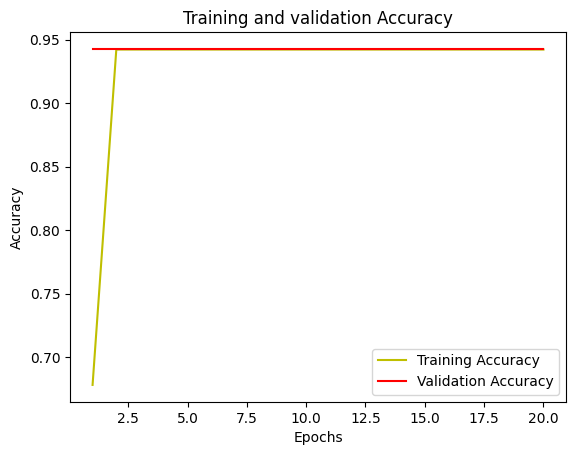

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [105]:
model = load_model('D:/Acres/January 2025/Assignment 8/Models/Unet/test.hdf5')

In [110]:
import tensorflow as tf


In [125]:
# Load the model (assuming it's in the SavedModel format)
model = tf.keras.models.load_model('D:/Acres/January 2025/Assignment 8/Models/Unet/test.hdf5')


from tensorflow.keras.models import load_model
model = load_model('D:/Acres/January 2025/Assignment 8/Models/Unet/test.hdf5')



In [119]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify

# Directory paths
input_dir = r"D:\Acres\January 2025\Assignment 8\AgriculturalField-Seg\test\original_test"
output_dir = r"D:\Acres\January 2025\Assignment 8\AgriculturalField-Seg\test\Model_Predicted"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the trained model
model = load_model('path_to_your_model')  # Provide the correct path to the saved model

# Function to predict patches and reassemble the full image
def predict_and_reassemble(image_path, patch_size=256):
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert to grayscale if the model expects grayscale input
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    
    # Create patches from the grayscale image
    patches = patchify(img_gray, (patch_size, patch_size), step=128)  # 128 for overlap
    
    # Prepare an empty array to store the predicted image
    predicted_patches = np.zeros_like(patches)
    
    # Iterate over each patch to predict and store the result
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j, :, :]
            patch = np.expand_dims(patch, axis=-1)  # Add channel dimension (grayscale)
            patch = np.expand_dims(patch, axis=0)  # Add batch dimension
            
            # Predict the patch
            prediction = model.predict(patch)  # Predict the patch
            
            # Store the predicted patch
            predicted_patches[i, j, :, :] = prediction[0]
    
    # Reassemble the full predicted image
    predicted_img = unpatchify(predicted_patches, img_gray.shape)
    
    return predicted_img

# Process each image in the directory
for image_name in os.listdir(input_dir):
    if image_name.endswith('.jpg'):
        image_path = os.path.join(input_dir, image_name)
        
        # Predict the segmentation for the image
        predicted_image = predict_and_reassemble(image_path)
        
        # Save the predicted image
        output_path = os.path.join(output_dir, image_name)
        cv2.imwrite(output_path, predicted_image)
        print(f"Processed {image_name} and saved prediction.")


ValueError: File format not supported: filepath=path_to_your_model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(path_to_your_model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).